# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Spring 2025

## Setup

You shouldn't have to change anything in these cells

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cpu


In [2]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [3]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

In [5]:
## Pick a model architecture
#net = models.NetA().to(device)
net = models.NetB().to(device)

## Checkpoint name for this model
#model_checkpoint = "netA_standard.pt"
model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.84265; TrainLoss: 0.43202; TestAcc: 0.88980; TestLoss: 0.31422
Epoch: [ 1 / 20 ]; TrainAcc: 0.90407; TrainLoss: 0.26506; TestAcc: 0.90630; TestLoss: 0.26062
Epoch: [ 2 / 20 ]; TrainAcc: 0.91997; TrainLoss: 0.22207; TestAcc: 0.91070; TestLoss: 0.24352
Epoch: [ 3 / 20 ]; TrainAcc: 0.92898; TrainLoss: 0.19597; TestAcc: 0.91450; TestLoss: 0.24511
Epoch: [ 4 / 20 ]; TrainAcc: 0.93623; TrainLoss: 0.17453; TestAcc: 0.91230; TestLoss: 0.24796
Epoch: [ 5 / 20 ]; TrainAcc: 0.94280; TrainLoss: 0.15633; TestAcc: 0.92320; TestLoss: 0.22739
Epoch: [ 6 / 20 ]; TrainAcc: 0.94965; TrainLoss: 0.13944; TestAcc: 0.92080; TestLoss: 0.23968
Epoch: [ 7 / 20 ]; TrainAcc: 0.95440; TrainLoss: 0.12574; TestAcc: 0.92130; TestLoss: 0.25455
Epoch: [ 8 / 20 ]; TrainAcc: 0.95910; TrainLoss: 0.11221; TestAcc: 0.91980; TestLoss: 0.26398
Epoch: [ 9 / 20 ]; TrainAcc: 0.96448; TrainLoss: 0.09790; TestAcc: 0.92020; TestLoss: 0.26387
Epoch: [ 10 / 20 ]; TrainAcc: 0.96708; TrainLoss: 0.08961; T

**Visualize some perturbed samples**

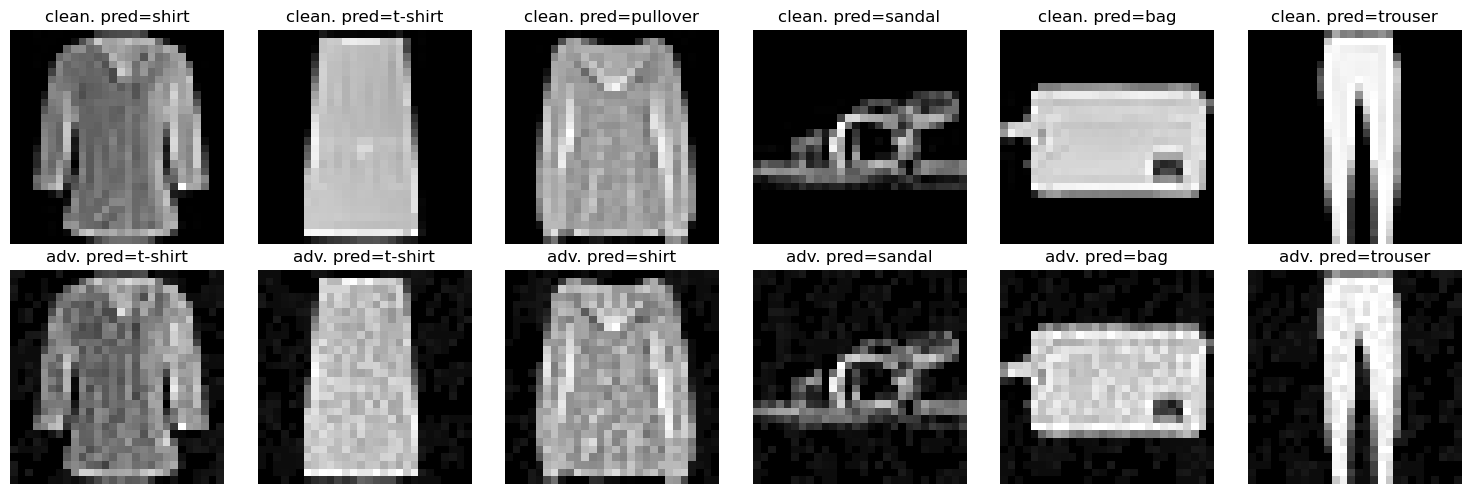

In [21]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))
for data,labels in test_loader:
        data = data.to(device); labels = labels.to(device)

        ###
        # Compute and apply adversarial perturbation to data
        EPS= 0.1
        ITS= 10
        ALP = 1.85*(EPS/ITS)

        ###
        #adv_data = attacks.PGD_attack(model=net, device=device, dat=data, lbl=labels, eps=EPS, alpha=ALP, iters=ITS, rand_start=True)
        #adv_data = attacks.FGSM_attack(net, device, data, labels, eps=EPS)
        adv_data = attacks.rFGSM_attack(net, device, data, labels, eps=EPS)
        # Compute preds
        with torch.no_grad():
            clean_outputs = net(data)
            _,clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()
            adv_outputs = net(adv_data)
            _,adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()
        
        # Plot some samples
        inds = random.sample(list(range(data.size(0))),6)
        plt.figure(figsize=(15,5))
        for jj in range(6):
            plt.subplot(2,6,jj+1);plt.imshow(data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))
        for jj in range(6):
            plt.subplot(2,6,6+jj+1);plt.imshow(adv_data[inds[jj],0].cpu().numpy(),cmap='gray');plt.axis("off");
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))
        plt.tight_layout()
        plt.show()


        break

## Test Attacks - Whitebox & Blackbox

Don't forget to plot accuracy vs. epsilon curves!

In [ ]:
## Load pretrained models
whitebox = models.NetA()
blackbox = models.NetB()

whitebox.load_state_dict(torch.load()) # TODO
blackbox.load_state_dict(torch.load()) # TODO

whitebox = whitebox.to(device); blackbox = blackbox.to(device)
whitebox.eval(); blackbox.eval()

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)
test_acc,_ = test_model(blackbox,test_loader,device)
print("Initial Accuracy of Blackbox Model: ",test_acc)

## Test the models against an adversarial attack

# TODO: Set attack parameters here
#ATK_EPS = ?
#ATK_ITERS = ?
#ATK_ALPHA = ?

whitebox_correct = 0.
blackbox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device)
    labels = labels.to(device)

    # TODO: Perform adversarial attack here

    # Sanity checking if adversarial example is "legal"
    assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
    assert(adv_data.max() == 1.)
    assert(adv_data.min() == 0.)

    # Compute accuracy on perturbed data
    with torch.no_grad():
        # Stat keeping - whitebox
        whitebox_outputs = whitebox(adv_data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        # Stat keeping - blackbox
        blackbox_outputs = blackbox(adv_data)
        _,blackbox_preds = blackbox_outputs.max(1)
        blackbox_correct += blackbox_preds.eq(labels).sum().item()
        running_total += labels.size(0)

    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(12):
            plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

# Print final
whitebox_acc = whitebox_correct/running_total
blackbox_acc = blackbox_correct/running_total

print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

print("Done!")

## Test Robust Models

Don't forget to plot accuracy vs. epsilon curves!

In [ ]:
whitebox = models.NetA()
whitebox.load_state_dict(torch.load()) # TODO: Load your robust models
whitebox = whitebox.to(device)
whitebox.eval();

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)

## Test the model against an adversarial attack

# TODO: Set attack parameters here
#ATK_EPS = ?
#ATK_ITERS = ?
#ATK_ALPHA = ?

whitebox_correct = 0.
running_total = 0.
for batch_idx,(data,labels) in enumerate(test_loader):
    data = data.to(device)
    labels = labels.to(device)

    # TODO: Perform adversarial attack here

    # Sanity checking if adversarial example is "legal"
    assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
    assert(adv_data.max() == 1.)
    assert(adv_data.min() == 0.)

    # Compute accuracy on perturbed data
    with torch.no_grad():
        whitebox_outputs = whitebox(adv_data)
        _,whitebox_preds = whitebox_outputs.max(1)
        whitebox_correct += whitebox_preds.eq(labels).sum().item()
        running_total += labels.size(0)

    # Plot some samples
    if batch_idx == 1:
        plt.figure(figsize=(15,5))
        for jj in range(12):
            plt.subplot(2,6,jj+1);plt.imshow(adv_data[jj,0].cpu().numpy(),cmap='gray');plt.axis("off")
        plt.tight_layout()
        plt.show()

# Print final
whitebox_acc = whitebox_correct/running_total
print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

print("Done!")